# Импорты

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [3]:
import os
print(os.getcwd())

d:\AVClassificator


In [4]:
print(os.getcwd())
# Путь к данным
data_dir = os.path.join(os.getcwd(), 'dataset')

# Печать содержимого папки dataset
print("Содержимое dataset:", os.listdir(data_dir))

# Проверка наличия папок train, test, validation
for sub_dir in ['train', 'test', 'validation']:
    path = os.path.join(data_dir, sub_dir)
    print(f"Папка {sub_dir} существует:", os.path.exists(path))
    print(f"Содержимое {sub_dir}:", os.listdir(path) if os.path.exists(path) else "Не существует")


d:\AVClassificator
Содержимое dataset: ['test', 'train', 'validation']
Папка train существует: True
Содержимое train: ['Anti-aircraft', 'Armored combat support vehicles', 'Armored personnel carriers', 'Infantry fighting vehicles', 'Light armored vehicles', 'light utility vehicles', 'Mine-protected vehicles', 'Prime movers and trucks', 'Self-propelled artillery', 'tanks']
Папка test существует: True
Содержимое test: ['Anti-aircraft', 'Armored combat support vehicles', 'Armored personnel carriers', 'Infantry fighting vehicles', 'Light armored vehicles', 'light utility vehicles', 'Mine-protected vehicles', 'Prime movers and trucks', 'Self-propelled artillery', 'tanks']
Папка validation существует: True
Содержимое validation: ['Anti-aircraft', 'Armored combat support vehicles', 'Armored personnel carriers', 'Infantry fighting vehicles', 'Light armored vehicles', 'light utility vehicles', 'Mine-protected vehicles', 'Prime movers and trucks', 'Self-propelled artillery', 'tanks']


In [14]:
img_height, img_width = 256, 256

In [26]:
import matplotlib.pyplot as plt

# Пути к данным
data_dir = os.path.join(os.getcwd(), 'dataset');

# Загрузка данных
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(256, 256),
    batch_size=32,
    labels='inferred',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(256, 256),
    batch_size=32,
    labels='inferred',
)

Found 10414 files belonging to 10 classes.
Found 3719 files belonging to 10 classes.


Оценка сбалансированности 

Количество изображений в каждом классе:
Anti-aircraft: 942 изображений (9.05%)
Armored combat support vehicles: 937 изображений (9.00%)
Armored personnel carriers: 944 изображений (9.06%)
Infantry fighting vehicles: 947 изображений (9.09%)
Light armored vehicles: 951 изображений (9.13%)
light utility vehicles: 967 изображений (9.29%)
Mine-protected vehicles: 1179 изображений (11.32%)
Prime movers and trucks: 1170 изображений (11.23%)
Self-propelled artillery: 1188 изображений (11.41%)
tanks: 1189 изображений (11.42%)


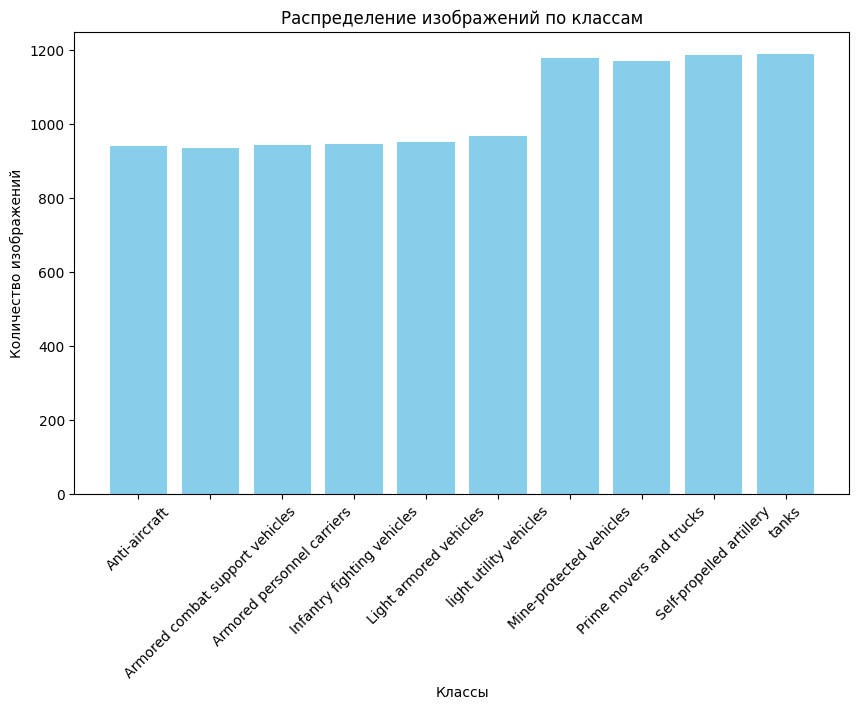


Среднее количество изображений на класс: 1041.40
Стандартное отклонение количества изображений по классам: 114.73
Датасет несбалансирован — стоит рассмотреть технику балансировки, например, аугментацию данных.


In [27]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Укажите путь к основной папке с датасетом
train_data_dir = os.path.join(data_dir, 'train');

# Считаем количество изображений в каждом классе
class_counts = Counter()
for class_name in os.listdir(train_data_dir):
    class_dir = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith(('jpg', 'jpeg', 'png'))])
        class_counts[class_name] = num_images

# Выводим количество изображений в каждом классе
total_images = sum(class_counts.values())
print("Количество изображений в каждом классе:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} изображений ({(count / total_images) * 100:.2f}%)")

# Построим диаграмму для наглядного отображения
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Классы")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=45)
plt.show()

# Оценка сбалансированности: вычислим стандартное отклонение
mean_count = total_images / len(class_counts)
std_dev = (sum((count - mean_count) ** 2 for count in class_counts.values()) / len(class_counts)) ** 0.5
print(f"\nСреднее количество изображений на класс: {mean_count:.2f}")
print(f"Стандартное отклонение количества изображений по классам: {std_dev:.2f}")

# Интерпретация результата
if std_dev < 0.1 * mean_count:
    print("Датасет достаточно сбалансирован.")
else:
    print("Датасет несбалансирован — стоит рассмотреть технику балансировки, например, аугментацию данных.")


Для нормализации значений пикселей можно добавить tf.keras.layers.Rescaling для всех значений в диапазоне от 0 до 1:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./256.0)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Визуализация

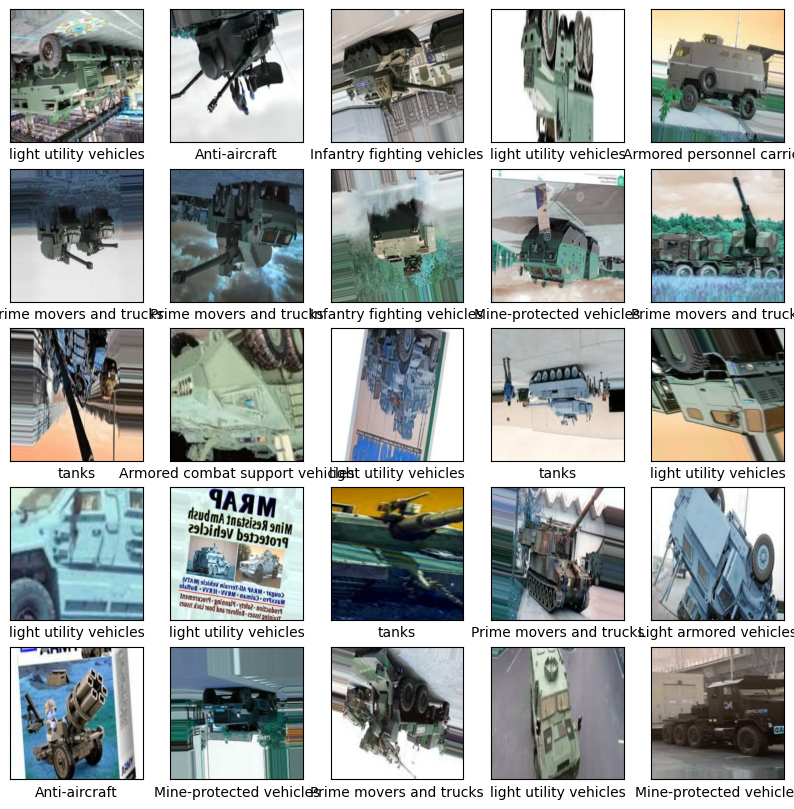

In [10]:
# Определение классов 
class_names = ["Anti-aircraft", "Armored combat support vehicles", "Armored personnel carriers", 
               "Infantry fighting vehicles", "Light armored vehicles", "light utility vehicles", 
               "Mine-protected vehicles", "Prime movers and trucks", "Self-propelled artillery", "tanks"]

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):  # Берем один пакет данных
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.xlabel(class_names[labels[i]])
plt.show()


Создание модели     

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers, Input

num_classes = len(class_names)

model =  Sequential([
Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

Компиляция модели

In [30]:
model.compile(
    optimizer='adam',              # Оптимизатор, может быть 'adam', 'sgd', и т.д.
    loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
    metrics=['accuracy']          # Метрика для оценки точности
)

Обучение модели

In [31]:
history = model.fit(
    train_ds,                      # Тренировочный датасет
    epochs=10,                     # Количество эпох
    validation_data=test_ds,       # Тестовый датасет для оценки модели на каждой эпохе
    batch_size=32,                 # Размер батча
)


Epoch 1/10


326/326 ━━━━━━━━━━━━━━━━━━━━ 224s 674ms/step - accuracy: 0.1300 - loss: 2.3430 - val_accuracy: 0.2218 - val_loss: 2.1629
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 209s 641ms/step - accuracy: 0.2922 - loss: 1.9892 - val_accuracy: 0.3065 - val_loss: 2.0895
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 208s 637ms/step - accuracy: 0.5798 - loss: 1.2525 - val_accuracy: 0.3092 - val_loss: 3.0518
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 206s 631ms/step - accuracy: 0.8436 - loss: 0.4767 - val_accuracy: 0.3245 - val_loss: 3.8415
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 206s 631ms/step - accuracy: 0.9460 - loss: 0.1920 - val_accuracy: 0.3366 - val_loss: 4.4641
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 206s 632ms/step - accuracy: 0.9618 - loss: 0.1236 - val_accuracy: 0.3307 - val_loss: 5.6008
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 206s 633ms/step - accuracy: 0.9779 - loss: 0.0824 - val_accuracy: 0.3436 - val_loss: 4.7053
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 206s 630ms/step - accuracy: 0.9812 - loss: 0.07

Оценка модели

In [32]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.3589 - loss: 6.1382
Test accuracy: 0.3511696755886078


In [33]:
model.save('models/model2_30.keras')

In [34]:
# Предсказания на тестовом наборе данных
y_pred = model.predict(test_ds)
y_pred = tf.argmax(y_pred, axis=1)  # Переводим вероятности в метки

# Реальные метки
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())

117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step


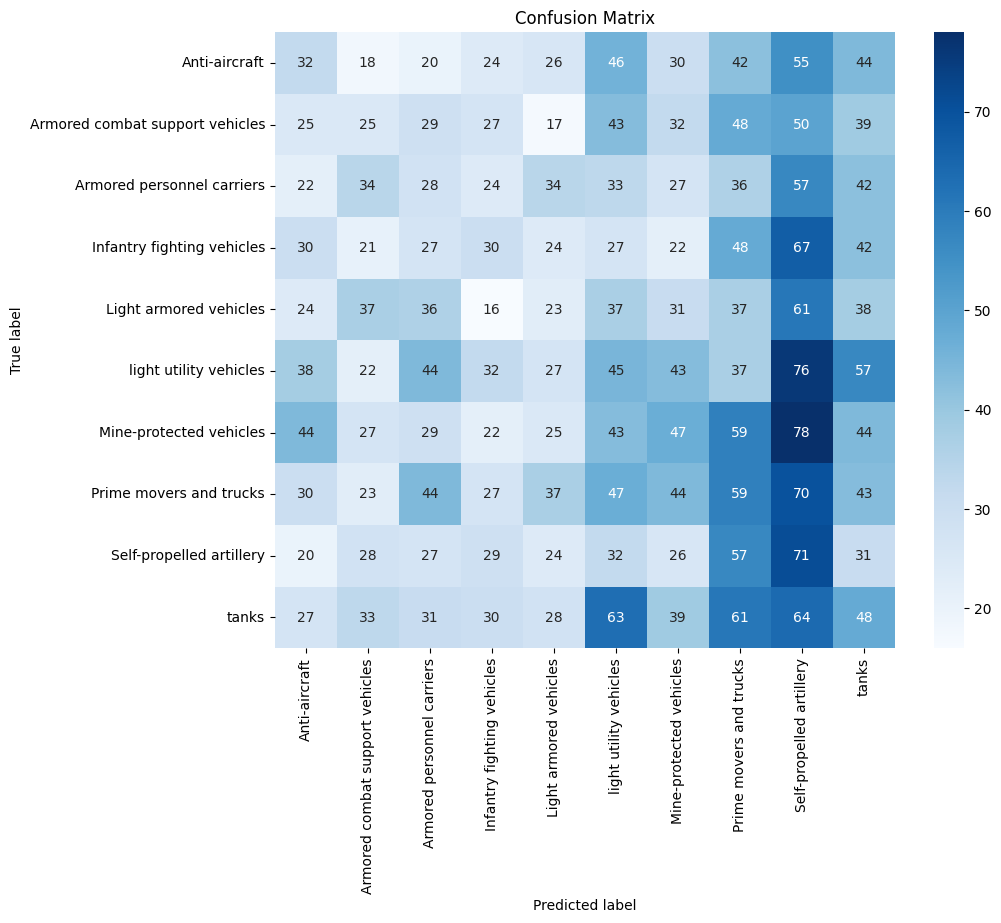

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Построение confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Визуализация с помощью Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()